In [36]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")

In [37]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")

In [38]:
llm.invoke("hello, check")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnJ88zDZoex03Ks48qdrEUA8LRqE5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f7f41def-32e0-4987-949f-37315b637a64-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [39]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent


In [40]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply",update={"sum":result})

In [41]:
add_number({"num1":10,"num2":20})

addition is 30


Command(update={'sum': 30}, goto='multiply')

In [42]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [43]:
### creating one dummy multi agent

from langchain_core.tools import tool
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    print("########transfer_to_multiplication_expert########")
    return


In [44]:
### creating one dummy aditiona agent

from langchain_core.tools import tool
@tool
def transfer_to_addition_expert():
    """Ask multiplication agent for help"""
    print("########transfer_to_addition_expert########")
    return

In [45]:
llm_with_tool=llm.bind_tools([transfer_to_multiplication_expert])

In [46]:
response=llm_with_tool.invoke("hi")
response

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 43, 'total_tokens': 53, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnJ89L8GpIUXolEF0xCZmpDY59wOH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f744f76f-49fb-40f3-b33a-a24b5bd9dd14-0', usage_metadata={'input_tokens': 43, 'output_tokens': 10, 'total_tokens': 53, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [47]:
response=llm_with_tool.invoke("what is 2 multiply 2?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7YUoOAKbKrEvAbeRs15Z29yn', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 50, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnJ8AZ41RNfO9nqRlG4D48i1NVrYa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abe4be22-871c-4656-84bc-0410aae55b4a-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_7YUoOAKbKrEvAbeRs15Z29yn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 15, 'total_tokens': 65, 'input_token_details'

In [48]:
response.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_7YUoOAKbKrEvAbeRs15Z29yn',
  'type': 'tool_call'}]

In [49]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END
from langchain_core.messages import BaseMessage, HumanMessage

In [50]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    print("########additional_expert########")

    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    print(f"########additional_expert########messages#{messages}")

    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    print(f"########additional_expert########ai_msg#{ai_msg}")
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        print(f"########additional_expert########tool_msg#{tool_msg}")
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}
    

In [51]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    print("########multiplication_expert########")

    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    print(f"########multiplication_expert########messages#{messages}")
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)

    print(f"########multiplication_expert########ai_msg#{ai_msg}")
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        print(f"########multiplication_expert########tool_msg#{tool_msg}")
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}
    

In [52]:
graph=StateGraph(MessagesState)

graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

graph.add_edge(START,"additional_expert")

app=graph.compile()

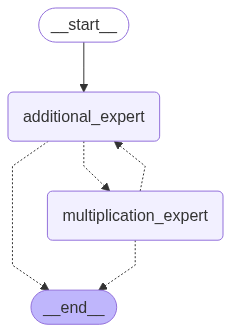

In [53]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [54]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

########additional_expert########
########additional_expert########messages#[{'role': 'system', 'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'}, HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='c81c03b0-8e3e-4ed0-a3e8-b1ea9f8f3a35')]
########additional_expert########ai_msg#content='' additional_kwargs={'tool_calls': [{'id': 'call_i7epCamcbhKf597GlOqnfgfx', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 86, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-0

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='c81c03b0-8e3e-4ed0-a3e8-b1ea9f8f3a35'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_i7epCamcbhKf597GlOqnfgfx', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 86, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnJ8BSBWU8ifAOPwP2PdNSafxRdSJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bea177ad-f886-4a97-a66e-8fb83fe1466e-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 

########additional_expert########
########additional_expert########messages#[{'role': 'system', 'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'}, HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='6e441522-a0ba-435c-9dea-05a1f9af6d66')]
########additional_expert########ai_msg#content='' additional_kwargs={'tool_calls': [{'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl8lk8ZcSUpyHeotylXF9GamwQJsf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--738b207f-96c8-4f85-9752-3245333054ec-0' tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'type': 'tool_call'}] usage_metadata={'input_tokens': 86, 'output_tokens': 14, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
########additional_expert########tool_msg#{'role': 'tool', 'content': 'Successfully transferred', 'tool_call_id': 'call_K7i78C5I583UJYgSnhuNtiSc'}
########multiplication_expert########
########multiplication_expert########messages#[{'role': 'system', 'content': 'You are a multiplication expert, you can ask an addition expert for help with addition. Always do your portion of calculation before the handoff.'}, HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='6e441522-a0ba-435c-9dea-05a1f9af6d66'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl8lk8ZcSUpyHeotylXF9GamwQJsf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--738b207f-96c8-4f85-9752-3245333054ec-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 14, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), ToolMessage(content='Successfully transferred', id='202c651a-a2e5-47a2-add2-7a7f730a3290', tool_call_id='call_K7i78C5I583UJYgSnhuNtiSc')]
########multiplication_expert########ai_msg#content='I have calculated that (3 + 5) * 12 equals 96.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 114, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl8llycgYnxFtbIWfOtWjyrf0zNni', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--82361fce-9bc3-4801-b187-d81ca83f6ada-0' usage_metadata={'input_tokens': 114, 'output_tokens': 18, 'total_tokens': 132, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='6e441522-a0ba-435c-9dea-05a1f9af6d66'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl8lk8ZcSUpyHeotylXF9GamwQJsf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--738b207f-96c8-4f85-9752-3245333054ec-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_K7i78C5I583UJYgSnhuNtiSc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 14, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  ToolMessage(content='Successfully transferred', id='202c651a-a2e5-47a2-add2-7a7f730a3290', tool_call_id='call_K7i78C5I583UJYgSnhuNtiSc'),
  AIMessage(content='I have calculated that (3 + 5) * 12 equals 96.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 114, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl8llycgYnxFtbIWfOtWjyrf0zNni', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--82361fce-9bc3-4801-b187-d81ca83f6ada-0', usage_metadata={'input_tokens': 114, 'output_tokens': 18, 'total_tokens': 132, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


### Network based A2A collaboration using real tools


In [55]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [56]:
search_tool.invoke("who is a current pm of uk?")

[{'title': 'UK Prime Minister List in Chronological order from 1721 to 2025 PDF',
  'url': 'https://sarkarilist.in/uk-prime-minister-list/',
  'content': 'Robert Walpole holds the distinction of being the first Prime Minister of the UK and is also recognized as the longest-serving Prime Minister. As of now, Boris Johnson is the current Prime Minister of Great Britain. Below is the table listing the UK Prime Ministers from 1721 to 2025, including their respective terms in office and party affiliations. [...] | 75 | David Cameron | (2010–16) | Conservative |\n| 76 | Theresa May | (2016–19) | Conservative |\n| 77 | Boris Johnson | (2019– Incumbent) | Conservative | [...] | 65 | Harold Macmillan | (1957–63) | Conservative |\n| 66 | Alec Douglas-Home | (1963–64) | Conservative |\n| 67 | Harold Wilson | (1964–70; 1st time) | Labour |\n| 68 | Edward Heath | (1970–74) | Conservative |\n| 69 | Harold Wilson | (1974–76; 2nd time) | Labour |\n| 70 | James Callaghan | (1976–79) | Labour |\n| 71 | 

In [57]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""
repl.run(code)


'10\n'

In [58]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [59]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [60]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [61]:
def get_next_node(last_message:BaseMessage, goto:str):
    print(f"#########get_next_node#########last_message# {last_message}")
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [62]:
from langgraph.graph import END
def researcher(state:MessagesState)->Command[Literal["graph_plotter", "__end__"]]:
    print(f"#########researcher#########state# {state}")
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    print(f"#########researcher#########result# {result}")
    goto=get_next_node(result["messages"][-1],"graph_plotter")
    print(f"#########researcher#########goto# {goto}")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    print(f"#########researcher#########last result# {result}")
    return Command(update={"messages": result["messages"]},goto=goto)

In [63]:
def graph_plotter(state:MessagesState)->Command[Literal["researcher", "__end__"]]:
    print(f"#########graph_plotter#########state# {state}")
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    print(f"#########graph_plotter#########result# {result}")
    goto=get_next_node(result["messages"][-1],"researcher")
    print(f"#########graph_plotter#########goto# {goto}")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="graph_plotter")
    print(f"#########graph_plotter#########last result# {result}")
    return Command(update={"messages": result["messages"]},goto=goto)

In [64]:
a2a_graph=StateGraph(MessagesState)

a2a_graph.add_node("researcher",researcher)
a2a_graph.add_node("graph_plotter",graph_plotter)

a2a_graph.add_edge(START,"researcher")

a2a_app=a2a_graph.compile()

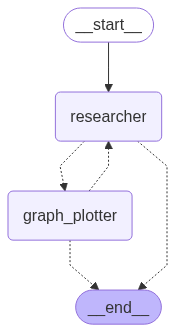

In [65]:
from IPython.display import Image, display
display(Image(a2a_app.get_graph(xray=True).draw_mermaid_png()))

#########researcher#########state# {'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then plot a line chart of it.", additional_kwargs={}, response_metadata={}, id='6eb3ded0-b04e-4baa-b4e3-a1dde492694e')]}
#########researcher#########result# {'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then plot a line chart of it.", additional_kwargs={}, response_metadata={}, id='6eb3ded0-b04e-4baa-b4e3-a1dde492694e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FPlp5X1E9EvTFESvR0bofjyi', 'function': {'arguments': '{"query":"UK GDP over the past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 198, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cac

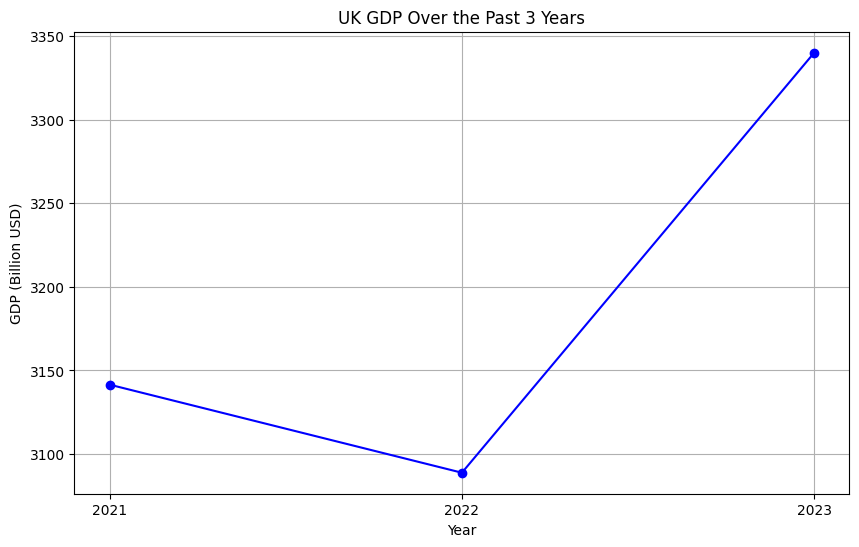

#########graph_plotter#########result# {'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then plot a line chart of it.", additional_kwargs={}, response_metadata={}, id='6eb3ded0-b04e-4baa-b4e3-a1dde492694e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FPlp5X1E9EvTFESvR0bofjyi', 'function': {'arguments': '{"query":"UK GDP over the past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 198, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnJ8L9Gj4HFN9dsrZoOdGh5JpCLcj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ebd

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then plot a line chart of it.", additional_kwargs={}, response_metadata={}, id='6eb3ded0-b04e-4baa-b4e3-a1dde492694e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FPlp5X1E9EvTFESvR0bofjyi', 'function': {'arguments': '{"query":"UK GDP over the past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 198, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnJ8L9Gj4HFN9dsrZoOdGh5JpCLcj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ebd452c8-2594-4f3b-be49-3850edb06409-0',

In [66]:
a2a_app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then plot a line chart of it.")],},{"recursion_limit": 10})
